In [42]:
# CELL 1 — imports & paths
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.rcParams["figure.figsize"] = (12,6)
sns.set(style="whitegrid")

# Project layout: notebook in Aero-Nova-2/eda/
ROOT = Path.cwd().parents[0]   # adjust to Path.cwd() if your notebook is at project root
PROC = ROOT / "processed"
RES  = ROOT / "results"
RES.mkdir(exist_ok=True)

masters = {
    "aqi": PROC / "aqi_master.csv",
    "weather": PROC / "weather_master.csv",
    "traffic": PROC / "traffic_master.csv"
}

print("ROOT:", ROOT)
for k,p in masters.items():
    print(f"{k:8} -> {p}  exists: {p.exists()}")


ROOT: c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2
aqi      -> c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\processed\aqi_master.csv  exists: True
weather  -> c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\processed\weather_master.csv  exists: True
traffic  -> c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\processed\traffic_master.csv  exists: True


In [43]:
# CELL 2 — load masters (safe encoding fallback)
dfs = {}
for k, p in masters.items():
    if not p.exists():
        raise FileNotFoundError(f"Missing master file: {p}  — run preprocessing or place files correctly.")
    print("Loading", p)
    try:
        df = pd.read_csv(p, low_memory=False, encoding="utf-8")
    except Exception:
        df = pd.read_csv(p, low_memory=False, encoding="latin1")
    dfs[k] = df
    print(" ->", k, "shape:", df.shape)
    display(df.head(2))


Loading c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\processed\aqi_master.csv
 -> aqi shape: (12550, 14)


,station,lat,lon,timestamp,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,type
0,Indore - MG Road,22.718,75.847,2025-10-31 06:00:00,404.81,0.27,3.85,44.34,1.67,21.01,23.20,0.62,2,Historical
1,Indore - MG Road,22.718,75.847,2025-10-31 07:00:00,399.62,0.31,3.82,50.95,1.73,21.03,23.44,0.85,2,Historical


Loading c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\processed\weather_master.csv
 -> weather shape: (646, 12)


,city,latitude,longitude,timestamp,temperature_°c,humidity_%,pressure_hpa,wind_speed_m/s,wind_direction_°,cloudiness_%,visibility_m,source
0,Indore,22.7196,75.8577,2025-11-09 00:00:00,13.6,65,1015.8,5.1,63,0,10000.0,Open-Meteo
1,Indore,22.7196,75.8577,2025-11-09 01:00:00,13.5,63,1016.4,4.9,62,0,10000.0,Open-Meteo


Loading c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\processed\traffic_master.csv
 -> traffic shape: (8976, 23)


,timestamp,city,location,traffic_volume,avg_speed,travel_time_index,congestion_level,road_capacity_utilization,incident_reports,environmental_impact,...,pedestrian_cyclist_count,weather_conditions,roadwork_activity,latitude,longitude,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure
0,2022-01-01,Indiranagar,100 Feet Road,50590.0,50.230299,1.5,100.0,100.0,0.0,151.18,...,111.0,Clear,No,23.07205,75.95555,24.0,528.5,370.5,0.910647,False
1,2022-01-01,Indiranagar,CMH Road,30825.0,29.377125,1.5,100.0,100.0,1.0,111.65,...,100.0,Clear,No,23.07205,75.95555,24.0,528.5,370.5,0.910647,False


In [44]:
# CELL 3 — normalize column names
def normalize_cols(df):
    df = df.copy()
    df.columns = [str(c).strip().lower().replace(" ", "_").replace("/", "_").replace("(", "").replace(")","") for c in df.columns]
    return df

for k in list(dfs.keys()):
    dfs[k] = normalize_cols(dfs[k])
    print(k, "columns:", dfs[k].columns.tolist()[:30])


aqi columns: ['station', 'lat', 'lon', 'timestamp', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'aqi', 'type']
weather columns: ['city', 'latitude', 'longitude', 'timestamp', 'temperature_°c', 'humidity_%', 'pressure_hpa', 'wind_speed_m_s', 'wind_direction_°', 'cloudiness_%', 'visibility_m', 'source']
traffic columns: ['timestamp', 'city', 'location', 'traffic_volume', 'avg_speed', 'travel_time_index', 'congestion_level', 'road_capacity_utilization', 'incident_reports', 'environmental_impact', 'public_transport_usage', 'traffic_signal_compliance', 'parking_usage', 'pedestrian_cyclist_count', 'weather_conditions', 'roadwork_activity', 'latitude', 'longitude', 'free_flow_speed', 'current_travel_time', 'free_flow_travel_time', 'confidence', 'road_closure']


In [45]:
# CELL 4 — parse timestamp-like columns and create date column
def find_and_parse_ts(df):
    df = df.copy()
    # prefer explicit 'timestamp'
    if "timestamp" in df.columns:
        ts = "timestamp"
    else:
        ts = None
        for c in df.columns:
            if any(x in c for x in ("timestamp","datetime","time","date","recorded")):
                ts = c
                break
    if ts is None:
        return None, df
    # parse to datetime (coerce bad formats)
    df[ts] = pd.to_datetime(df[ts], errors="coerce")
    df["date"] = pd.to_datetime(df[ts]).dt.date
    return ts, df

ts_map = {}
for k in list(dfs.keys()):
    ts_col, dfs[k] = find_and_parse_ts(dfs[k])
    ts_map[k] = ts_col
    print(k, "timestamp column:", ts_col, "| parsed non-null:", int(dfs[k][ts_col].notna().sum()) if ts_col else "NA")


aqi timestamp column: timestamp | parsed non-null: 12550
weather timestamp column: timestamp | parsed non-null: 646
traffic timestamp column: timestamp | parsed non-null: 8694


In [46]:
# CELL 5 — quick diagnostic of date coverage
for k, df in dfs.items():
    print(f"\n{k} shape:", df.shape)
    if "date" in df.columns and not df["date"].isna().all():
        try:
            print(" date min/max:", df["date"].min(), "/", df["date"].max())
        except Exception as e:
            print(" date min/max error:", e)
    else:
        print(" no usable date column or all null")



aqi shape: (12550, 15)
 date min/max: 2025-10-31 / 2025-11-18

weather shape: (646, 13)
 date min/max: 2025-11-09 / 2025-11-18

traffic shape: (8976, 24)
 date min/max error: '<=' not supported between instances of 'datetime.date' and 'float'


In [47]:
# CELL 6 — try to coerce numeric-like object columns to numeric
for k, df in dfs.items():
    df = df.copy()
    coerced = []
    for c in df.columns:
        if df[c].dtype == object:
            sample = df[c].dropna().astype(str).head(20).tolist()
            # if sample contains digits, attempt cleaning & coercion
            if any(any(ch.isdigit() for ch in s) for s in sample):
                cleaned = df[c].astype(str).str.replace(r"[^0-9\.\-eE]", "", regex=True)
                num = pd.to_numeric(cleaned, errors="coerce")
                if num.notna().sum() > 0:
                    df[c] = num
                    coerced.append(c)
    dfs[k] = df
    print(k, "coerced cols:", coerced)


aqi coerced cols: []
weather coerced cols: []
traffic coerced cols: ['location']


In [48]:
# CELL 7 — daily medians (numeric cols only)
daily = {}
for k, df in dfs.items():
    d = df.copy()
    if "date" not in d.columns:
        print(k, "no date -> creating empty daily")
        daily[k] = pd.DataFrame(columns=["date"])
        continue
    # ensure date column is normalized to python date or NaT
    d['date'] = pd.to_datetime(d['date'], errors='coerce').dt.date
    numcols = d.select_dtypes(include=[np.number]).columns.tolist()
    if len(numcols) == 0:
        print(k, "no numeric cols found for aggregation; daily will be date-only")
        daily[k] = pd.DataFrame({"date": sorted(d['date'].dropna().unique())})
    else:
        agg = d.groupby('date')[numcols].median().reset_index()
        daily[k] = agg
    print(k, "daily shape:", daily[k].shape, "| numeric cols:", numcols[:12])


aqi daily shape: (14, 12) | numeric cols: ['lat', 'lon', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'aqi']
weather daily shape: (8, 10) | numeric cols: ['latitude', 'longitude', 'temperature_°c', 'humidity_%', 'pressure_hpa', 'wind_speed_m_s', 'wind_direction_°', 'cloudiness_%', 'visibility_m']
traffic daily shape: (927, 19) | numeric cols: ['location', 'traffic_volume', 'avg_speed', 'travel_time_index', 'congestion_level', 'road_capacity_utilization', 'incident_reports', 'environmental_impact', 'public_transport_usage', 'traffic_signal_compliance', 'parking_usage', 'pedestrian_cyclist_count']


In [49]:
# CELL 8 — inspect the three daily tables
for k in ["aqi","weather","traffic"]:
    dfk = daily.get(k)
    print(f"\n== {k} daily shape:", None if dfk is None else dfk.shape)
    if dfk is not None and not dfk.empty:
        display(dfk.head(3))
        print(k, "dates sample:", dfk["date"].head(5).tolist())
    else:
        print(k, "daily empty")



== aqi daily shape: (14, 12)


,date,lat,lon,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
0,2025-10-31,23.085,75.9645,424.120,0.0,4.44,43.265,1.20,20.70,23.44,1.26,2.0
1,2025-11-01,23.085,75.9645,326.225,0.0,2.78,52.710,1.39,23.27,26.48,1.89,2.0
2,2025-11-02,23.085,75.9645,315.160,0.0,2.37,57.020,0.97,15.71,17.85,1.93,2.0


aqi dates sample: [datetime.date(2025, 10, 31), datetime.date(2025, 11, 1), datetime.date(2025, 11, 2), datetime.date(2025, 11, 3), datetime.date(2025, 11, 4)]

== weather daily shape: (8, 10)


,date,latitude,longitude,temperature_°c,humidity_%,pressure_hpa,wind_speed_m_s,wind_direction_°,cloudiness_%,visibility_m
0,2025-11-09,23.07205,75.95555,18.45,51.0,1014.3,5.60,53.0,0.0,10000.0
1,2025-11-10,23.07205,75.95555,18.65,51.0,1014.7,3.35,127.0,0.0,10000.0
2,2025-11-11,23.07205,75.95555,18.95,52.0,1015.7,3.40,88.0,0.0,10000.0


weather dates sample: [datetime.date(2025, 11, 9), datetime.date(2025, 11, 10), datetime.date(2025, 11, 11), datetime.date(2025, 11, 12), datetime.date(2025, 11, 13)]

== traffic daily shape: (927, 19)


,date,location,traffic_volume,avg_speed,travel_time_index,congestion_level,road_capacity_utilization,incident_reports,environmental_impact,public_transport_usage,traffic_signal_compliance,parking_usage,pedestrian_cyclist_count,latitude,longitude,free_flow_speed,current_travel_time,free_flow_travel_time,confidence
0,2022-01-01,4.0,34167.0,39.785971,1.50000,100.000000,100.0,1.0,118.334,43.093296,82.604704,74.251467,104.5,23.07205,75.95555,24.0,528.5,370.5,0.910647
1,2022-01-02,4.0,29106.0,40.069991,1.50000,90.409855,100.0,2.0,108.212,38.626706,75.023318,62.199482,101.0,23.07205,75.95555,24.0,528.5,370.5,0.910647
2,2022-01-03,4.0,24968.0,36.727691,1.39491,87.202143,100.0,1.0,99.936,53.275264,87.389247,87.618726,109.0,23.07205,75.95555,24.0,528.5,370.5,0.910647


traffic dates sample: [datetime.date(2022, 1, 1), datetime.date(2022, 1, 2), datetime.date(2022, 1, 3), datetime.date(2022, 1, 4), datetime.date(2022, 1, 5)]


In [50]:
# CELL 9 — robust force-parse if dates look mixed (run only if needed)
from dateutil import parser

def force_parse_date_series(s):
    if pd.api.types.is_datetime64_any_dtype(s):
        return pd.to_datetime(s).dt.date
    out = []
    import datetime
    for v in s:
        if pd.isna(v):
            out.append(pd.NaT); continue
        if isinstance(v, (pd.Timestamp, datetime.datetime, np.datetime64)):
            try:
                out.append(pd.to_datetime(v).date())
            except:
                out.append(pd.NaT)
            continue
        if isinstance(v, datetime.date) and not isinstance(v, datetime.datetime):
            out.append(v); continue
        if isinstance(v, (float,int)):
            out.append(pd.NaT); continue
        try:
            out.append(parser.parse(str(v)).date())
        except:
            try:
                pdv = pd.to_datetime(v, errors='coerce')
                out.append(pdv.date() if not pd.isna(pdv) else pd.NaT)
            except:
                out.append(pd.NaT)
    return pd.Series(out)

for k in list(daily.keys()):
    if "date" in daily[k].columns:
        before = daily[k]['date'].notna().sum()
        daily[k]['date'] = force_parse_date_series(daily[k]['date'])
        after = daily[k]['date'].notna().sum()
        print(f"{k} dates non-null before/after: {before}/{after}")


aqi dates non-null before/after: 14/14
weather dates non-null before/after: 8/8
traffic dates non-null before/after: 927/927


In [51]:
# CELL 10 — merge and clean
comb = daily["weather"].merge(daily["traffic"], on="date", how="outer", suffixes=("_w","_t"))
comb = comb.merge(daily["aqi"], on="date", how="outer", suffixes=("","_a"))
print("Raw combined shape:", comb.shape)

# drop rows where all numeric columns are NaN (keep rows with at least one numeric)
numeric_cols = comb.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    comb = comb.dropna(subset=numeric_cols, how="all").sort_values("date").reset_index(drop=True)
else:
    comb = comb.sort_values("date").reset_index(drop=True)
print("Combined after dropping fully-empty rows:", comb.shape)
display(comb.head(6))


Raw combined shape: (942, 39)
Combined after dropping fully-empty rows: (942, 39)


,date,latitude_w,longitude_w,temperature_°c,humidity_%,pressure_hpa,wind_speed_m_s,wind_direction_°,cloudiness_%,visibility_m,...,lon,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
0,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# CELL 11 — final coercion for numeric-like object columns in combined DF
comb = comb.copy()
coerced = []
for c in comb.columns:
    if comb[c].dtype == object:
        cleaned = comb[c].astype(str).str.replace(r"[^0-9\.\-eE]", "", regex=True)
        coerced_col = pd.to_numeric(cleaned, errors="coerce")
        if coerced_col.notna().sum() > 0:
            comb[c] = coerced_col
            coerced.append(c)
print("Coerced columns in combined:", coerced)

num = comb.select_dtypes(include=[np.number]).copy()
# drop numeric cols that are all NaN
allnan = [c for c in num.columns if num[c].isna().all()]
if allnan:
    print("Dropping all-NaN numeric cols:", allnan)
    num = num.drop(columns=allnan)
print("Numeric columns used for correlation:", num.columns.tolist())


Coerced columns in combined: []
Numeric columns used for correlation: ['latitude_w', 'longitude_w', 'temperature_°c', 'humidity_%', 'pressure_hpa', 'wind_speed_m_s', 'wind_direction_°', 'cloudiness_%', 'visibility_m', 'location', 'traffic_volume', 'avg_speed', 'travel_time_index', 'congestion_level', 'road_capacity_utilization', 'incident_reports', 'environmental_impact', 'public_transport_usage', 'traffic_signal_compliance', 'parking_usage', 'pedestrian_cyclist_count', 'latitude_t', 'longitude_t', 'free_flow_speed', 'current_travel_time', 'free_flow_travel_time', 'confidence', 'lat', 'lon', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'aqi']


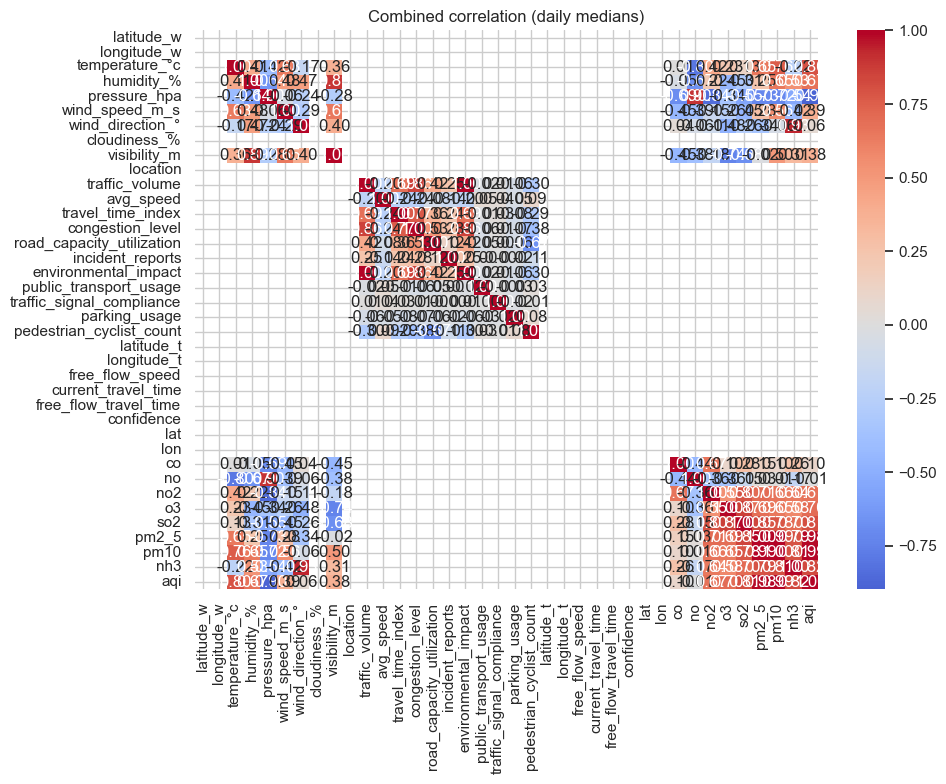

Saved heatmap: c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\results\combined_corr_heatmap.png
Top correlated pairs (abs):
environmental_impact  traffic_volume      1.000000
aqi                   pm10                0.988314
pm10                  pm2_5               0.987775
pm2_5                 aqi                 0.979810
nh3                   wind_direction_°    0.933605
pressure_hpa          no                  0.897650
humidity_%            visibility_m        0.889581
so2                   o3                  0.871638
traffic_volume        congestion_level    0.858126
environmental_impact  congestion_level    0.858126
pm2_5                 so2                 0.849045
no2                   pressure_hpa        0.838460
dtype: float64


In [53]:
# CELL 12 — correlation heatmap and top pairs
if num.shape[1] == 0:
    print("No numeric columns available — inspect comb.columns and daily tables.")
else:
    corr = num.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Combined correlation (daily medians)")
    out = RES / "combined_corr_heatmap.png"
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved heatmap:", out)

    # top correlated pairs (absolute)
    cabs = corr.abs().copy()
    np.fill_diagonal(cabs.values, 0)
    flat = cabs.unstack().sort_values(ascending=False).drop_duplicates()
    print("Top correlated pairs (abs):")
    print(flat.head(12))
    with open(RES / "combined_top_pairs.txt", "w") as fh:
        fh.write(str(flat.head(40)))


Skipping pair (missing): pm25 temperature_c
Skipping pair (missing): pm25 humidity
Skipping pair (missing): traffic_volume pm25


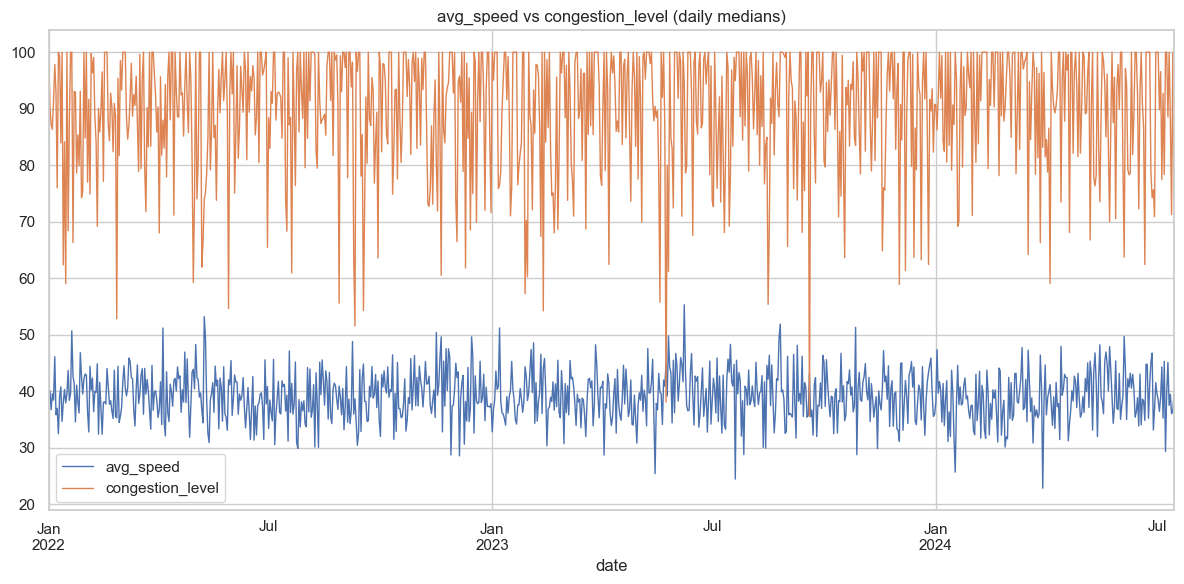

Saved: c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\results\avg_speed_vs_congestion_level.png


In [54]:
# CELL 13 — plot a few pair comparisons if present
pairs = [
    ("pm25", "temperature_c"),
    ("pm25", "humidity"),
    ("traffic_volume", "pm25"),
    ("avg_speed", "congestion_level")
]

for a,b in pairs:
    if a in comb.columns and b in comb.columns:
        tmp = comb[["date", a, b]].dropna().sort_values("date")
        if tmp.empty:
            continue
        tmp['date'] = pd.to_datetime(tmp['date'])
        fig, ax = plt.subplots()
        tmp.set_index('date')[[a,b]].plot(ax=ax, linewidth=1)
        ax.set_title(f"{a} vs {b} (daily medians)")
        out = RES / f"{a}_vs_{b}.png"
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print("Saved:", out)
    else:
        print("Skipping pair (missing):", a, b)


In [ ]:
# CELL 14 — save combined daily and summary
comb_out = RES / "combined_daily.csv"
comb.to_csv(comb_out, index=False)
print("Saved combined daily CSV ->", comb_out)
print("Combined shape:", comb.shape)
print("Numeric cols used:", num.columns.tolist())
print("Files in results/:", sorted([p.name for p in RES.glob("*")]))



Saved combined daily CSV -> c:\Users\aksha\OneDrive\Desktop\Aero-Nova-2\results\combined_daily.csv
Combined shape: (942, 39)
Numeric cols used: ['latitude_w', 'longitude_w', 'temperature_°c', 'humidity_%', 'pressure_hpa', 'wind_speed_m_s', 'wind_direction_°', 'cloudiness_%', 'visibility_m', 'location', 'traffic_volume', 'avg_speed', 'travel_time_index', 'congestion_level', 'road_capacity_utilization', 'incident_reports', 'environmental_impact', 'public_transport_usage', 'traffic_signal_compliance', 'parking_usage', 'pedestrian_cyclist_count', 'latitude_t', 'longitude_t', 'free_flow_speed', 'current_travel_time', 'free_flow_travel_time', 'confidence', 'lat', 'lon', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'aqi']
Files in results/: ['.gitkeep', 'aqi_daily_median.csv', 'avg_speed_vs_congestion_level.png', 'combined_corr_heatmap.png', 'combined_daily.csv', 'combined_top_pairs.txt', 'speed_vs_congestion.png', 'traffic_daily_congestion.png', 'traffic_daily_median.csv', 'traffi